In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import time
import os
import copy

from aad.datasets import DATASET_LIST, DataContainer
from aad.utils import master_seed

master_seed(2**12)

plt.rcParams['figure.figsize'] = [16,8]
plt.ion()  # interactive mode

In [2]:
NAME = 'CIFAR10'
DATA_ROOT = os.path.join('..', 'data')
print(DATASET_LIST[NAME])

classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
assert len(classes) == 10

{'name': 'CIFAR10', 'type': 'image', 'size': 60000, 'num_classes': 10, 'dim_data': (3, 32, 32)}


In [3]:
dc = DataContainer(DATASET_LIST[NAME], DATA_ROOT)
dc()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
BATCH_SIZE = 128

train_dl = dc.get_dataloader(batch_size=BATCH_SIZE, is_train=True)
test_dl = dc.get_dataloader(batch_size=BATCH_SIZE, is_train=False)
print(len(train_dl.dataset), len(test_dl.dataset))

50000 10000


In [5]:
def imshow(grid, title=None):
    grid = grid.numpy().transpose((1, 2, 0))
    plt.imshow(grid)

    if title is not None:
        plt.title(title)

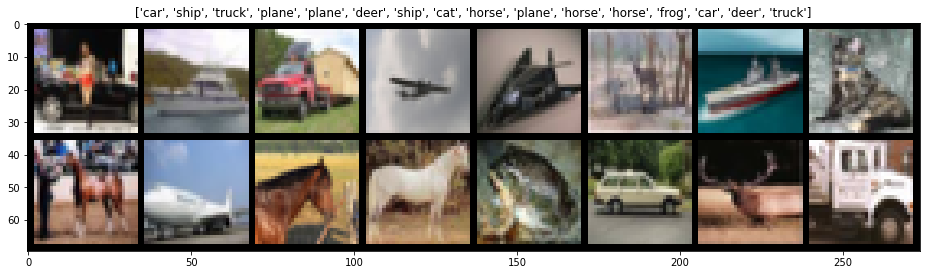

In [6]:
imgs, lbls = next(iter(train_dl))
grid = tv.utils.make_grid(imgs[:16])
titles = [classes[i.item()] for i in lbls[:16]]
imshow(grid, title=titles)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
# model = tv.models.resnet18(pretrained=True)
# model = tv.models.mobilenet_v2(pretrained=True, progress=False)
# model = tv.models.resnext50_32x4d(pretrained=True, progress=False)
model = tv.models.resnet50(pretrained=True, progress=False)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/lukec/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [17]:
# num_fcin = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(num_fcin, 10)

num_fcin = model.fc.in_features
model.fc = nn.Linear(num_fcin, 10)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
def train(model, optimizer, loss_fn, loader):
    model.train()
    total_loss = 0.0
    corrects = 0.0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        b_size = x.size(0)

        optimizer.zero_grad()
        score = model(x)
        loss = loss_fn(score, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.cpu().item() * b_size
        pred = score.max(1, keepdim=True)[1]
        corrects += pred.eq(y.view_as(pred)).sum().cpu().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    acc = corrects / n
    return total_loss, acc

In [20]:
def validate(model, loss_fn, loader):
    model.eval()
    total_loss = 0.0
    corrects = 0.0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        b_size = x.size(0)

        score = model(x)
        loss = loss_fn(score, y)
        total_loss += loss.cpu().item() * b_size
        pred = score.max(1, keepdim=True)[1]
        corrects += pred.eq(y.view_as(pred)).sum().cpu().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    acc = corrects / n
    return total_loss, acc

In [15]:
MAX_EPOCHS = 20

best_model_state = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(MAX_EPOCHS):
    time_start = time.time()

    tr_loss, tr_acc = train(model, optimizer, loss_fn, train_dl)
    te_loss, te_acc = validate(model, loss_fn, test_dl)

    time_elapsed = time.time() - time_start

    print('[{}/{}] {:d}m {:.3f}s Train loss: {:.4f} acc: {:.4f} - Test loss: {:.4f} acc: {:.4f}'.format(
        epoch+1, MAX_EPOCHS,
        int(time_elapsed // 60), time_elapsed % 60,
        tr_loss, tr_acc * 100, te_loss, te_acc * 100
    ))

    if te_acc >= best_acc:
        best_acc = te_acc
        best_model_state = copy.deepcopy(model.state_dict())

model.load_state_dict(best_model_state)
loss, acc = validate(model, loss_fn, test_dl)
print('Test loss: {:.4f} acc: {:.4f}'.format(loss, acc * 100))

[1/20] 0m 38.202s Train loss: 0.3409 acc: 88.5460 - Test loss: 0.5211 acc: 82.8700
[2/20] 0m 38.238s Train loss: 0.2305 acc: 92.1960 - Test loss: 0.5532 acc: 82.9600
[3/20] 0m 38.229s Train loss: 0.1718 acc: 94.0980 - Test loss: 0.5705 acc: 83.6300
[4/20] 0m 38.218s Train loss: 0.1292 acc: 95.6220 - Test loss: 0.5820 acc: 84.2300
[5/20] 0m 38.205s Train loss: 0.1041 acc: 96.4680 - Test loss: 0.5962 acc: 84.2900
[6/20] 0m 38.219s Train loss: 0.0770 acc: 97.3180 - Test loss: 0.6248 acc: 84.3500
[7/20] 0m 38.556s Train loss: 0.0728 acc: 97.5320 - Test loss: 0.6513 acc: 84.3700
[8/20] 0m 38.734s Train loss: 0.0594 acc: 97.9940 - Test loss: 0.6585 acc: 84.4700
[9/20] 0m 38.133s Train loss: 0.0556 acc: 98.1140 - Test loss: 0.6699 acc: 84.5100
[10/20] 0m 38.118s Train loss: 0.0438 acc: 98.5600 - Test loss: 0.6632 acc: 84.6700
[11/20] 0m 38.110s Train loss: 0.0340 acc: 98.8260 - Test loss: 0.6757 acc: 85.1500
[12/20] 0m 38.288s Train loss: 0.0361 acc: 98.8280 - Test loss: 0.6786 acc: 85.0400
[

- resnet18 \[20/20\] 0m 17.695s Train loss: 0.0364 acc: 98.8220 - Test loss: 0.9188 acc: 81.6600
- mobilenet_v2 \[20/20\] 0m 14.498s Train loss: 0.1327 acc: 95.2600 - Test loss: 0.7405 acc: 81.2500
- resnext50 \[20/20\] 0m 38.136s Train loss: 0.0214 acc: 99.3120 - Test loss: 0.7336 acc: 85.6700